# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data

# Import all modules here
from sklearn.preprocessing import LabelBinarizer
from tensorflow.contrib.layers import flatten

import cv2
import pickle
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import tensorflow as tf

# Visualizations will be shown in the notebook.
%matplotlib inline

np.random.seed(10)

# TODO: fill this in based on where you saved the training and testing data
training_file = "../train.p"
testing_file = "../test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
print('Loaded data!')

Loaded data!


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[-3:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

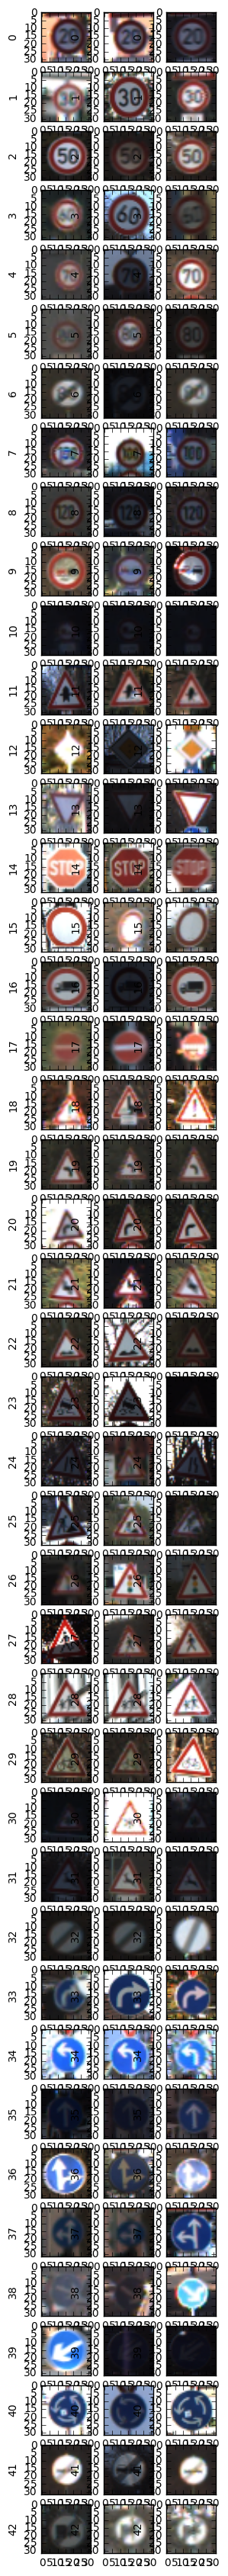

In [3]:
###
# Plot sample images for all classes
###
plot_index=1
images_per_class=3
fig = plt.figure(figsize=(images_per_class, n_classes), dpi=32)
for class_num in np.arange(n_classes):
    indexes=np.random.choice(
        np.where(y_test==class_num)[0], 
        size=images_per_class, 
        replace=False)
    for index in np.arange(images_per_class):
        fig.add_subplot(n_classes, images_per_class, plot_index)
        plt.imshow(X_test[indexes[index]])
        plt.ylabel(str(class_num))
        plot_index += 1

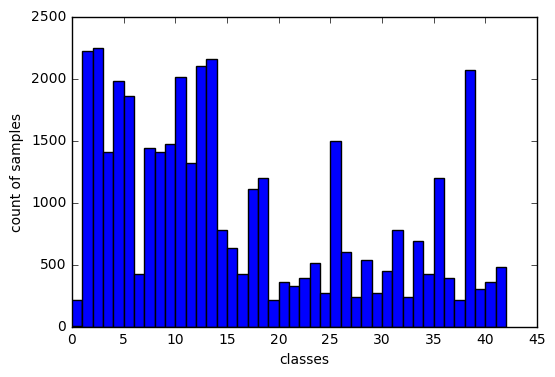

In [4]:
###
# Plot a histogram to get a sense of the class distribution
###
histogram=plt.figure()
bins = np.arange(0, n_classes)
plt.hist(y_train, bins)
plt.ylabel('count of samples')
plt.xlabel('classes')
plt.show()

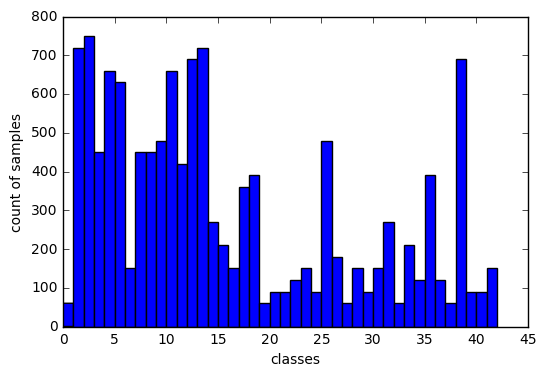

In [5]:
###
# Plot a histogram to get a sense of the tests class distribution
###
histogram=plt.figure()
bins = np.arange(0, n_classes)
plt.hist(y_test, bins)
plt.ylabel('count of samples')
plt.xlabel('classes')
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [6]:
###
# Preprocessing steps:
# 1. Convert image to yuv and histogram equalize and sharpen it.
# 2. Convert image to yuv and histogram equalize it.
# 3. Use both the above images as input to the model.
# Histogram equalization helps while dealing with a wide range 
# of brigtness/contrast settings in an image.
###

# Generate train, validation and test datasets
training_pct = 0.9
training_size = int(n_train * training_pct)
sample_indexes = np.arange(n_train)
np.random.shuffle(sample_indexes)
training_indexes = sample_indexes[0:training_size]
validation_indexes = sample_indexes[training_size:n_train]

X_train_final = np.empty([training_size] + [32, 32, 6], dtype=np.float32)
y_train_final = y_train[training_indexes]
X_valid_final = np.empty([n_train - training_size] + [32, 32, 6], dtype=np.float32)
y_valid_final = y_train[validation_indexes]
X_test_final = np.empty([X_test.shape[0], 32, 32, 6], dtype=np.float32)
y_test_final = y_test


# Preprocess data
## Feel free to use as many code cells as needed.
def pre_process(image):
    # Convert to yuv, this lets us histogram equalize images
    # which gets a better performance under varied lighting conditions
    image_out = np.empty(list(image.shape[0:2]) + [6], dtype=np.uint8)
    image_out[:, :, 0:3] = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    image_out[:, :, 3:6] = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    image_out[:, :, 0] = cv2.equalizeHist(image_out[:,:,0])
    image_out[:, :, 3] = cv2.equalizeHist(image_out[:,:,3])
    #overall sharpening
    kernel_sharpen = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    image_out[:, :, 0:3] = cv2.filter2D(image_out[:, :, 0:3], -1, kernel_sharpen)
    # normalize images
    return ((image_out-(255.0/2))/255.0)

for index in np.arange(len(training_indexes)):
    X_train_final[index] = pre_process(X_train[training_indexes[index]])
for index in np.arange(len(validation_indexes)):
    X_valid_final[index] = pre_process(X_train[validation_indexes[index]])
for index in np.arange(len(X_test_final)):
    X_test_final[index] = pre_process(X_test[index])

encoder = LabelBinarizer()
encoder.fit(y_train_final)
y_train_final = encoder.transform(y_train_final)
y_valid_final = encoder.transform(y_valid_final)
y_test_final = encoder.transform(y_test_final)
    
y_train_final = y_train_final.astype(np.float32)
y_valid_final = y_valid_final.astype(np.float32)
y_test_final = y_test_final.astype(np.float32)

X_train_augmented = None
y_train_augmented = None

print(X_train_final.shape)
print(y_train_final.shape)
print(X_valid_final.shape)
print(y_valid_final.shape)
print(X_test_final.shape)
print(y_test_final.shape)
print("Preprocessed data.")

(35288, 32, 32, 6)
(35288, 43)
(3921, 32, 32, 6)
(3921, 43)
(12630, 32, 32, 6)
(12630, 43)
Preprocessed data.


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
12


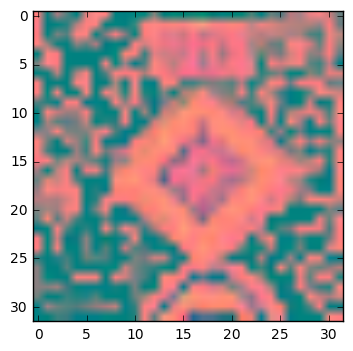

In [7]:
# Sanity check dataset.
ii = 300
plt.imshow(((X_valid_final[ii][:, :, 0:3] * 255.0) + (255.0/2)).astype(np.uint8))
print(y_valid_final[ii])
print(np.argmax(y_valid_final[ii]))

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [8]:
###
# 1. Training validation and test splits were made in the previous cell.
# 
# The idea is to shuffle the training set, and split it 90-10 for train and 
# validation the test set is used as-is.
#
# 2. Additional data.
# 
# Before images are used for training the image batch is translated, 
# rotated, scaled by +/- T pixels, +/- R degrees, +/- S scale factor (chosen 
# from a uniform distribution). This is done to increase translation/rotation/scale 
# invariance in the resultant model. (See: process_image_batch in this cell)
###

# Source: http://jepsonsblog.blogspot.com/2012/11/rotation-in-3d-using-opencvs.html
# This utility rotates/translates/scales images in 3D
def rotateImage(input_image, alpha, beta, gamma, dx, dy, dz, f):
    alpha = (alpha - 90.0) * math.pi / 180.0
    beta = (beta - 90.0) * math.pi / 180.0
    gamma = (gamma - 90.0) * math.pi / 180.0
    # get width and height for ease of use in matrices
    w, h, c = input_image.shape
    
    # Projection 2D -> 3D matrix
    a1 = np.array([
      [1, 0, -w/2],
      [0, 1, -h/2],
      [0, 0,    0],
      [0, 0,    1]
    ])
    # Rotation matrices around the X, Y, and Z axis
    rx = np.array([
      [1,          0,           0, 0],
      [0, math.cos(alpha), -math.sin(alpha), 0],
      [0, math.sin(alpha),  math.cos(alpha), 0],
      [0,          0,           0, 1]
    ])
    ry = np.array([
      [math.cos(beta), 0, -math.sin(beta), 0],
      [0, 1,          0, 0],
      [math.sin(beta), 0,  math.cos(beta), 0],
      [0, 0,          0, 1]
    ])
    rz = np.array([
      [math.cos(gamma), -math.sin(gamma), 0, 0],
      [math.sin(gamma),  math.cos(gamma), 0, 0],
      [0,          0,           1, 0],
      [0,          0,           0, 1]
    ])
    # Composed rotation matrix with (rx, ry, rz)
    r = np.matmul(rx, np.matmul(ry, rz))
    #r = rx * ry * rz
    
    # Translation matrix
    t = np.array([
     [1, 0, 0, dx],
     [0, 1, 0, dy],
     [0, 0, 1, dz],
     [0, 0, 0, 1]
    ])
    # 3D -> 2D matrix
    a2 = np.array([
      [f, 0, w/2, 0],
      [0, f, h/2, 0],
      [0, 0,   1, 0]
    ])
    
    # Final transformation matrix
    trans = np.matmul(a2, np.matmul(t, np.matmul(r, a1)))
    # Apply matrix transformation
    return cv2.warpPerspective(input_image, trans, (w, h))

# rotation_range - [low, high) in degrees to rotate the image
# translation_range - [low, high) in pixels to x and y translate the image
# scale_range - [low, high) in factor by which to scale the image
def process_image_batch(x, output, rotation_range, translation_range, scale_range):
    for ind in np.arange(len(x)):
        degrees = np.random.uniform(low=rotation_range[0], high=rotation_range[1])
        translation_x = np.random.uniform(low=translation_range[0], high=translation_range[1])
        translation_y = np.random.uniform(low=translation_range[0], high=translation_range[1])
        scale = np.random.uniform(low=scale_range[0], high=scale_range[1])
        
        output[ind] = rotateImage(x[ind], 90, 90, 90+degrees, translation_x, translation_y, 200, 200+scale)

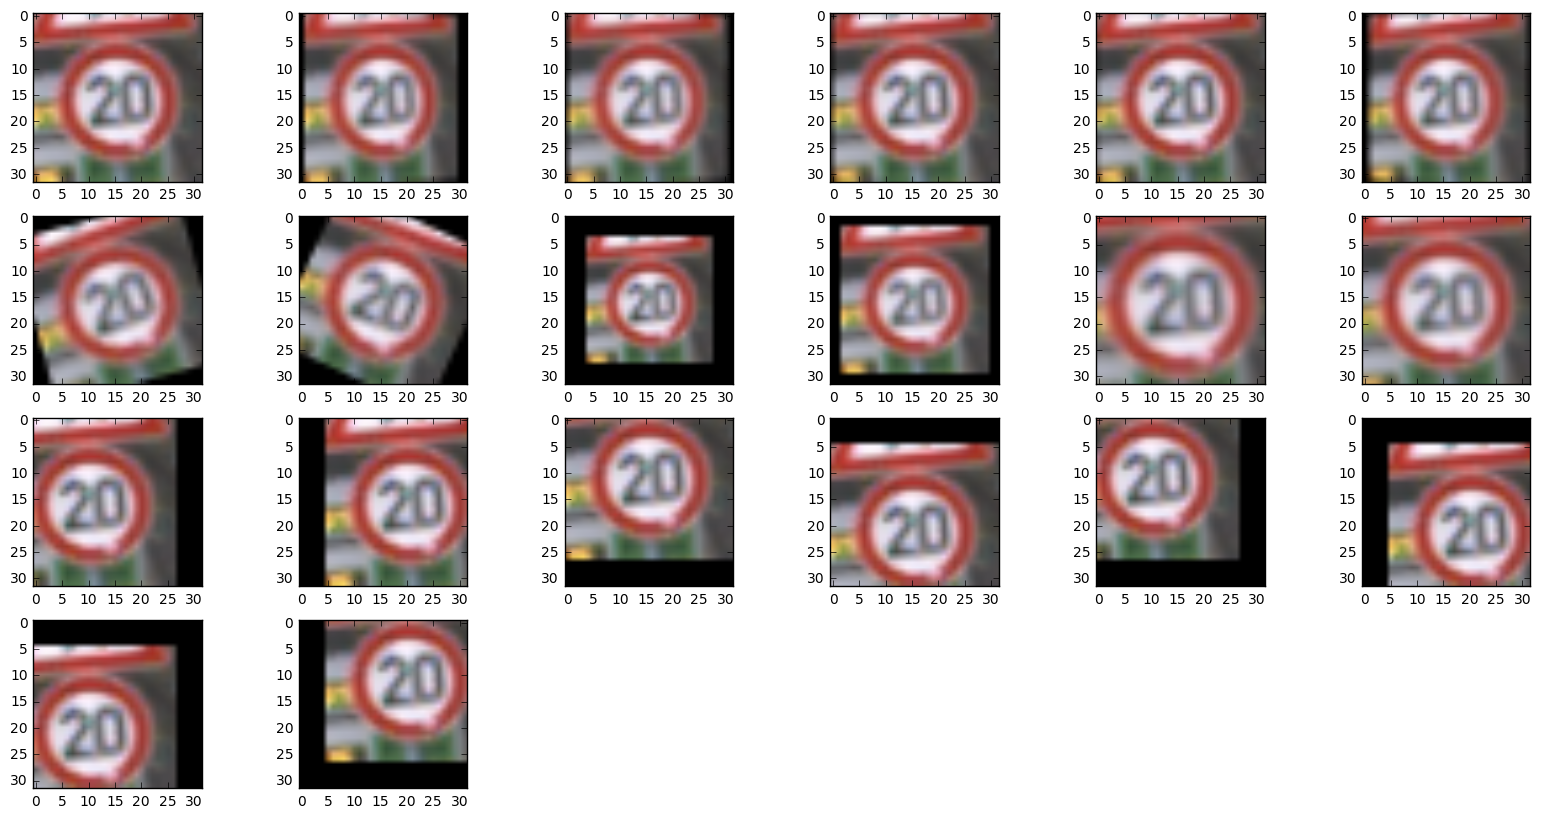

In [9]:
# Tests
fig = plt.figure(figsize=(20, 10), dpi=32)
# Original image
fig.add_subplot(4, 6, 1)
plt.imshow(X_train[10])
# Tilt image
fig.add_subplot(4, 6, 2)
plt.imshow(rotateImage(X_train[10], 90, 115, 90, 0, 0, 200, 200))
fig.add_subplot(4, 6, 3)
plt.imshow(rotateImage(X_train[10], 90, 110, 90, 0, 0, 200, 200))
fig.add_subplot(4, 6, 4)
plt.imshow(rotateImage(X_train[10], 90, 80, 90, 0, 0, 200, 200))
fig.add_subplot(4, 6, 5)
plt.imshow(rotateImage(X_train[10], 90, 85, 90, 0, 0, 200, 200))
fig.add_subplot(4, 6, 6)
plt.imshow(rotateImage(X_train[10], 90, 70, 90, 0, 0, 200, 200))
# Rotate image 
fig.add_subplot(4, 6, 7)
plt.imshow(rotateImage(X_train[10], 90, 90, 75, 0, 0, 200, 200))
fig.add_subplot(4, 6, 8)
plt.imshow(rotateImage(X_train[10], 90, 90, 115, 0, 0, 200, 200))
# Zoom out
fig.add_subplot(4, 6, 9)
plt.imshow(rotateImage(X_train[10], 90, 90, 90, 0, 0, 200, 150))
fig.add_subplot(4, 6, 10)
plt.imshow(rotateImage(X_train[10], 90, 90, 90, 0, 0, 200, 175))
# Zoom in
fig.add_subplot(4, 6, 11)
plt.imshow(rotateImage(X_train[10], 90, 90, 90, 0, 0, 200, 250))
fig.add_subplot(4, 6, 12)
plt.imshow(rotateImage(X_train[10], 90, 90, 90, 0, 0, 200, 220))
# Translate image left, right, top, down
fig.add_subplot(4, 6, 13)
plt.imshow(rotateImage(X_train[10], 90, 90, 90, -5, 0, 200, 200))
fig.add_subplot(4, 6, 14)
plt.imshow(rotateImage(X_train[10], 90, 90, 90, 5, 0, 200, 200))
fig.add_subplot(4, 6, 15)
plt.imshow(rotateImage(X_train[10], 90, 90, 90, 0, -5, 200, 200))
fig.add_subplot(4, 6, 16)
plt.imshow(rotateImage(X_train[10], 90, 90, 90, 0, 5, 200, 200))
# Translate image to 4 corners
fig.add_subplot(4, 6, 17)
plt.imshow(rotateImage(X_train[10], 90, 90, 90, -5, -5, 200, 200))
fig.add_subplot(4, 6, 18)
plt.imshow(rotateImage(X_train[10], 90, 90, 90, 5, 5, 200, 200))
fig.add_subplot(4, 6, 19)
plt.imshow(rotateImage(X_train[10], 90, 90, 90, -5, 5, 200, 200))
fig.add_subplot(4, 6, 20)
plt.imshow(rotateImage(X_train[10], 90, 90, 90, 5, -5, 200, 200))

In [10]:
###
# The spatial transformer layer is used to get the network to focus on key parts of an image.
# this layer is designed to learn parameters to generate a 6x6 translation matrix depending on
# an image to correct for rotations/translations, making the network more robust to these
# variations, this is a library in use, feel free to ignore this cell.
###

# Spatial transformation layer
# https://github.com/tensorflow/models/blob/master/transformer/spatial_transformer.py
def transformer(U, theta, out_size, name='SpatialTransformer', **kwargs):
    """Spatial Transformer Layer
    Implements a spatial transformer layer as described in [1]_.
    Based on [2]_ and edited by David Dao for Tensorflow.
    Parameters
    ----------
    U : float
        The output of a convolutional net should have the
        shape [num_batch, height, width, num_channels].
    theta: float
        The output of the
        localisation network should be [num_batch, 6].
    out_size: tuple of two ints
        The size of the output of the network (height, width)
    References
    ----------
    .. [1]  Spatial Transformer Networks
            Max Jaderberg, Karen Simonyan, Andrew Zisserman, Koray Kavukcuoglu
            Submitted on 5 Jun 2015
    .. [2]  https://github.com/skaae/transformer_network/blob/master/transformerlayer.py
    Notes
    -----
    To initialize the network to the identity transform init
    ``theta`` to :
        identity = np.array([[1., 0., 0.],
                             [0., 1., 0.]])
        identity = identity.flatten()
        theta = tf.Variable(initial_value=identity)
    """

    def _repeat(x, n_repeats):
        with tf.variable_scope('_repeat'):
            rep = tf.transpose(
                tf.expand_dims(tf.ones(shape=tf.pack([n_repeats, ])), 1), [1, 0])
            rep = tf.cast(rep, 'int32')
            x = tf.matmul(tf.reshape(x, (-1, 1)), rep)
            return tf.reshape(x, [-1])

    def _interpolate(im, x, y, out_size):
        with tf.variable_scope('_interpolate'):
            # constants
            num_batch = tf.shape(im)[0]
            height = tf.shape(im)[1]
            width = tf.shape(im)[2]
            channels = tf.shape(im)[3]

            x = tf.cast(x, 'float32')
            y = tf.cast(y, 'float32')
            height_f = tf.cast(height, 'float32')
            width_f = tf.cast(width, 'float32')
            out_height = out_size[0]
            out_width = out_size[1]
            zero = tf.zeros([], dtype='int32')
            max_y = tf.cast(tf.shape(im)[1] - 1, 'int32')
            max_x = tf.cast(tf.shape(im)[2] - 1, 'int32')

            # scale indices from [-1, 1] to [0, width/height]
            x = (x + 1.0)*(width_f) / 2.0
            y = (y + 1.0)*(height_f) / 2.0

            # do sampling
            x0 = tf.cast(tf.floor(x), 'int32')
            x1 = x0 + 1
            y0 = tf.cast(tf.floor(y), 'int32')
            y1 = y0 + 1

            x0 = tf.clip_by_value(x0, zero, max_x)
            x1 = tf.clip_by_value(x1, zero, max_x)
            y0 = tf.clip_by_value(y0, zero, max_y)
            y1 = tf.clip_by_value(y1, zero, max_y)
            dim2 = width
            dim1 = width*height
            base = _repeat(tf.range(num_batch)*dim1, out_height*out_width)
            base_y0 = base + y0*dim2
            base_y1 = base + y1*dim2
            idx_a = base_y0 + x0
            idx_b = base_y1 + x0
            idx_c = base_y0 + x1
            idx_d = base_y1 + x1

            # use indices to lookup pixels in the flat image and restore
            # channels dim
            im_flat = tf.reshape(im, tf.pack([-1, channels]))
            im_flat = tf.cast(im_flat, 'float32')
            Ia = tf.gather(im_flat, idx_a)
            Ib = tf.gather(im_flat, idx_b)
            Ic = tf.gather(im_flat, idx_c)
            Id = tf.gather(im_flat, idx_d)

            # and finally calculate interpolated values
            x0_f = tf.cast(x0, 'float32')
            x1_f = tf.cast(x1, 'float32')
            y0_f = tf.cast(y0, 'float32')
            y1_f = tf.cast(y1, 'float32')
            wa = tf.expand_dims(((x1_f-x) * (y1_f-y)), 1)
            wb = tf.expand_dims(((x1_f-x) * (y-y0_f)), 1)
            wc = tf.expand_dims(((x-x0_f) * (y1_f-y)), 1)
            wd = tf.expand_dims(((x-x0_f) * (y-y0_f)), 1)
            output = tf.add_n([wa*Ia, wb*Ib, wc*Ic, wd*Id])
            return output

    def _meshgrid(height, width):
        with tf.variable_scope('_meshgrid'):
            # This should be equivalent to:
            #  x_t, y_t = np.meshgrid(np.linspace(-1, 1, width),
            #                         np.linspace(-1, 1, height))
            #  ones = np.ones(np.prod(x_t.shape))
            #  grid = np.vstack([x_t.flatten(), y_t.flatten(), ones])
            x_t = tf.matmul(tf.ones(shape=tf.pack([height, 1])),
                            tf.transpose(tf.expand_dims(tf.linspace(-1.0, 1.0, width), 1), [1, 0]))
            y_t = tf.matmul(tf.expand_dims(tf.linspace(-1.0, 1.0, height), 1),
                            tf.ones(shape=tf.pack([1, width])))

            x_t_flat = tf.reshape(x_t, (1, -1))
            y_t_flat = tf.reshape(y_t, (1, -1))

            ones = tf.ones_like(x_t_flat)
            grid = tf.concat(0, [x_t_flat, y_t_flat, ones])
            return grid

    def _transform(theta, input_dim, out_size):
        with tf.variable_scope('_transform'):
            num_batch = tf.shape(input_dim)[0]
            height = tf.shape(input_dim)[1]
            width = tf.shape(input_dim)[2]
            num_channels = tf.shape(input_dim)[3]
            theta = tf.reshape(theta, (-1, 2, 3))
            theta = tf.cast(theta, 'float32')

            # grid of (x_t, y_t, 1), eq (1) in ref [1]
            height_f = tf.cast(height, 'float32')
            width_f = tf.cast(width, 'float32')
            out_height = out_size[0]
            out_width = out_size[1]
            grid = _meshgrid(out_height, out_width)
            grid = tf.expand_dims(grid, 0)
            grid = tf.reshape(grid, [-1])
            grid = tf.tile(grid, tf.pack([num_batch]))
            grid = tf.reshape(grid, tf.pack([num_batch, 3, -1]))

            # Transform A x (x_t, y_t, 1)^T -> (x_s, y_s)
            T_g = tf.batch_matmul(theta, grid)
            x_s = tf.slice(T_g, [0, 0, 0], [-1, 1, -1])
            y_s = tf.slice(T_g, [0, 1, 0], [-1, 1, -1])
            x_s_flat = tf.reshape(x_s, [-1])
            y_s_flat = tf.reshape(y_s, [-1])

            input_transformed = _interpolate(
                input_dim, x_s_flat, y_s_flat,
                out_size)

            output = tf.reshape(
                input_transformed, tf.pack([num_batch, out_height, out_width, num_channels]))
            return output

    with tf.variable_scope(name):
        output = _transform(theta, U, out_size)
        return output


def batch_transformer(U, thetas, out_size, name='BatchSpatialTransformer'):
    """Batch Spatial Transformer Layer
    Parameters
    ----------
    U : float
        tensor of inputs [num_batch,height,width,num_channels]
    thetas : float
        a set of transformations for each input [num_batch,num_transforms,6]
    out_size : int
        the size of the output [out_height,out_width]
    Returns: float
        Tensor of size [num_batch*num_transforms,out_height,out_width,num_channels]
    """
    with tf.variable_scope(name):
        num_batch, num_transforms = map(int, thetas.get_shape().as_list()[:2])
        indices = [[i]*num_transforms for i in xrange(num_batch)]
        input_repeated = tf.gather(U, tf.reshape(indices, [-1]))
        return transformer(input_repeated, thetas, out_size)

In [11]:
###
# Network architecture:
# The final network uses 1 spatial transform layer, 4 convolutional layers and two fully connected layers.
###
def parametric_relu(name, _x):
    alphas = tf.get_variable(name+'alpha', _x.get_shape()[-1], initializer=tf.constant_initializer(0.0), dtype=tf.float32)
    pos = tf.nn.relu(_x)
    neg = alphas * (_x - abs(_x)) * 0.5
    return pos + neg

def conv_plain(name, input_tensor, filter_size, in_ch, out_ch):
    conv_W = tf.get_variable(name + "_W", shape=[filter_size, filter_size, in_ch, out_ch], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv_b = tf.Variable(tf.zeros(out_ch), name=name + "_b")
    conv   = tf.nn.conv2d(input_tensor, conv_W, strides=[1, 1, 1, 1], padding='SAME') + conv_b
    return conv

def conv_relu_maxpool(name, input_tensor, filter_size, in_ch, out_ch, keep_prob):
    conv_W = tf.get_variable(name + "_W", shape=[filter_size, filter_size, in_ch, out_ch], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv_b = tf.Variable(tf.zeros(out_ch), name=name + "_b")
    conv   = tf.nn.conv2d(input_tensor, conv_W, strides=[1, 1, 1, 1], padding='SAME') + conv_b
    conv = parametric_relu(name, conv)
    conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv = tf.nn.dropout(conv, keep_prob)
    return conv

def fc_layer(name, input_tensor, neurons, should_relu, keep_prob):
    input_shape = [input_tensor.get_shape().as_list()[-1], neurons]
    fc_W     = tf.get_variable(name + "_W", shape=input_shape, initializer=tf.contrib.layers.xavier_initializer_conv2d())
    fc_b     = tf.Variable(tf.zeros(neurons), name=name + "_b")
    fc       = tf.matmul(input_tensor, fc_W) + fc_b
    if should_relu:
        fc = parametric_relu(name, fc)
        fc = tf.nn.dropout(fc, keep_prob)
    return fc

def transform_layer(name, input_tensor, keep_prob):
    input_shape = input_tensor.get_shape().as_list()
    input_tensor_flattened = flatten(input_tensor)
    # %% Create a fully-connected layer with 6 output nodes
    n_fc0 = 100
    W_fc0 = tf.get_variable(name + "W_fc0", shape=[input_tensor_flattened.get_shape().as_list()[-1], n_fc0], initializer=tf.contrib.layers.xavier_initializer_conv2d())
    b_fc0 = tf.Variable(tf.zeros(n_fc0), name=name + "b_fc0")
    h_fc0 = tf.matmul(input_tensor_flattened, W_fc0) + b_fc0
    h_fc0 = tf.nn.relu(h_fc0)
    h_fc0 = tf.nn.dropout(h_fc0, keep_prob)
    
    n_fc1 = 6
    W_fc1 = tf.get_variable(name + "W_fc1", shape=[n_fc0, n_fc1], initializer=tf.contrib.layers.xavier_initializer_conv2d())

    initial = np.array([[1., 0, 0], [0, 1., 0]])
    initial = initial.astype('float32')
    initial = initial.flatten()

    b_fc1 = tf.Variable(initial_value=initial, name='b_fc1')
    h_fc1 = tf.matmul(h_fc0, W_fc1) + b_fc1
    
    return transformer(input_tensor, h_fc1, (input_shape[1], input_shape[2]), name+"_st")

def nn_lenet(x, keep_prob):
    x = transform_layer("tl", x, keep_prob)
    conv1 = conv_relu_maxpool('l1', x, 3, 6, 100, keep_prob)
    conv2 = conv_relu_maxpool('l2', conv1, 3, 100, 150, keep_prob)
    conv3 = conv_relu_maxpool('l3', conv2, 3, 150, 250, keep_prob)
    conv4 = conv_relu_maxpool('l4', conv3, 3, 250, 500, keep_prob)
    
    flattened = flatten(conv4)

    fc1 = fc_layer('fc1', flattened, 512, True, keep_prob)
    return fc_layer('output', fc1, 43, False, keep_prob)

print('Constructed nn')

Constructed nn


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

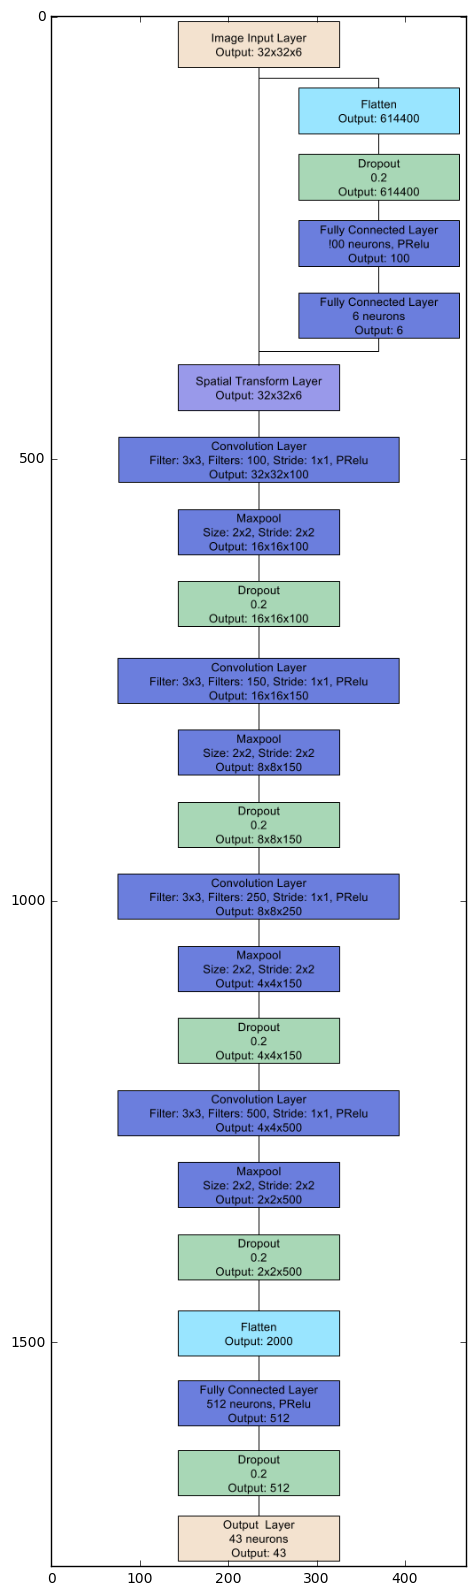

In [12]:
fig = plt.figure(figsize=(8, 20))
plt.imshow(cv2.imread('./Convolutional Neural Network.png'))

# The figure below depicts the structure of the convolutional neural network
# The network specs and characteristics are depicted in the image.
# Functionally the network is composed of 3 sections.
# 1. The Component that depending on an input image generates a parameter
#    vector of size 6 and multiplies that with the input image. This is a
#    spatial transform layer that corrects for rotations and translations
#    and focusses on key parts of the input image.
# 2. The Convolutional layers run convolution operations on the input image
#    mapping the input image into different forms (filters), as you go down
#    a convolution chain you learn higher order non-linear functions that
#    map an input to a more compact representation. The number and size
#    of the convolutional layers was a result of tuning the network.
# 3. The Last section is a fully connected neural network layer that learns
#    parameters to map the compact representation to a 43 element output
#    vector.

In [13]:
### Train your model here.\
### Feel free to use as many code cells as needed.
def total_accuracy(x, y, is_correct_predictor):
    x_splits = np.array_split(x, 4000)
    y_splits = np.array_split(y, 4000)
    correct_preds = 0.0
    for ind in np.arange(len(x_splits)):
        predictions = is_correct_predictor(x_splits[ind], y_splits[ind])
        correct_preds += len(np.where(predictions[0]==True)[0])
    return correct_preds / len(x)

def class_accuracy(x, y, n_classes, is_correct_predictor):
    x_splits = np.array_split(x, 4000)
    y_splits = np.array_split(y, 4000)
    correct_preds = np.zeros(n_classes, dtype=np.float32)
    total_preds = np.zeros(n_classes, dtype=np.float32)
    for ind in np.arange(len(x_splits)):
        predictions = is_correct_predictor(x_splits[ind], y_splits[ind])[0]
        for pred_ind in np.arange(len(predictions)):
            correct_preds_ind = np.argmax(y_splits[ind])
            if predictions[pred_ind] == True:
                correct_preds[correct_preds_ind] += 1
            total_preds[correct_preds_ind] += 1
    return (np.divide(correct_preds, total_preds), total_preds)

def print_summary():
    total_parameters = 0
    print("Network Summary:")
    for variable in tf.trainable_variables():
        shape = variable.get_shape()
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim.value
        print("name: %s, shape: %s, params: %d" % (variable.name, str(shape), variable_parameters))
        total_parameters += variable_parameters
    print("total parameters: %d" % total_parameters)

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 6])
y = tf.placeholder(tf.float32, shape=[None, 43])
keep_prob = tf.placeholder(tf.float32)
logits = nn_lenet(x, keep_prob)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
optimizer = tf.train.AdadeltaOptimizer(0.001).minimize(loss)
print('Constructed topology.')

is_correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))
print('Accuracy function created.')

saver = tf.train.Saver()

init = tf.global_variables_initializer()
rotation_range = (-10, 11)
translation_range = (-3, 4)
scale_range = (-20, 21)
print('Initialized variables.')

batch_size = 43
epochs = 500
batch_count = int(math.floor(len(X_train_final)/batch_size))
batch_features = np.empty([batch_size, 32, 32, 6], dtype=np.float32)
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
    session.run(init)
    print_summary()
    for epoch in np.arange(epochs):
        for batch_i in np.arange(batch_count):
            # Load pre-process data
            batch_start = batch_i * batch_size
            process_image_batch(
                X_train_final[batch_start:(batch_start + batch_size)],
                batch_features,
                rotation_range,
                translation_range,
                scale_range)
            batch_labels = y_train_final[batch_start:(batch_start + batch_size)]
            # Train the model
            session.run(
                optimizer, 
                feed_dict={
                    x: batch_features, 
                    y: batch_labels, 
                    keep_prob: 0.5
                })
        # After an epoch check accuracy on training subset
        t_a, t_l = session.run(
            [accuracy, loss], 
            feed_dict={
                x: X_train_final[0:4300], 
                y: y_train_final[0:4300], 
                keep_prob: 1.0
            })
        # After an epoch check accuracy on validation dataset
        v_a, v_l = session.run(
            [accuracy, loss], 
            feed_dict={
                x: X_valid_final[0:4300], 
                y: y_valid_final[0:4300], 
                keep_prob: 1.0
            })
        print("epoch: %d, train_accuracy: %f, train_loss: %f, valid_accuracy: %f, valid_loss: %f"
            % (epoch, t_a, t_l, v_a, v_l))
    # Finally test accuracy on test set, also check accuracy class-wise
    is_correct_predictor = lambda x_val, y_val: session.run(
        [is_correct_prediction], 
        feed_dict={
            x: x_val, 
            y: y_val, 
            keep_prob: 1.0
        })
    class_accuracy, preds_per_class = class_accuracy(X_test_final, y_test_final, n_classes, is_correct_predictor)
    for class_num in np.arange(n_classes):
        print("accuracy for class_num %d is %f count %d" % (class_num, class_accuracy[class_num], preds_per_class[class_num]))
    print("Testing accuracy: %f" % total_accuracy(X_test_final, y_test_final, is_correct_predictor))
    save_path = saver.save(session, "/tmp/model.ckpt")
    print("Model saved in file: %s" % save_path)
    

Constructed topology.
Accuracy function created.
Initialized variables.
Network Summary:
name: tlW_fc0:0, shape: (6144, 100), params: 614400
name: tlb_fc0:0, shape: (100,), params: 100
name: tlW_fc1:0, shape: (100, 6), params: 600
name: b_fc1:0, shape: (6,), params: 6
name: l1_W:0, shape: (3, 3, 6, 100), params: 5400
name: l1_b:0, shape: (100,), params: 100
name: l1alpha:0, shape: (100,), params: 100
name: l2_W:0, shape: (3, 3, 100, 150), params: 135000
name: l2_b:0, shape: (150,), params: 150
name: l2alpha:0, shape: (150,), params: 150
name: l3_W:0, shape: (3, 3, 150, 250), params: 337500
name: l3_b:0, shape: (250,), params: 250
name: l3alpha:0, shape: (250,), params: 250
name: l4_W:0, shape: (3, 3, 250, 500), params: 1125000
name: l4_b:0, shape: (500,), params: 500
name: l4alpha:0, shape: (500,), params: 500
name: fc1_W:0, shape: (2000, 512), params: 1024000
name: fc1_b:0, shape: (512,), params: 512
name: fc1alpha:0, shape: (512,), params: 512
name: output_W:0, shape: (512, 43), para

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

In [14]:
###
# 1. The model was trained to minimize softmax cross entropy of the logits output by the CNN.
# 2. Batch size used was 43, representing the number of classes in the dataset. (tuned)
# 3. The model was trained for 250 epochs.
# 4. For training I used the adadelta optimizer with an initial learning rate of 0.001, adadelta
#    adjusts the learning rate so there were no hyper parameters here.
# 5. I also used xavier (glorot uniform) initialization instead of a uniform normal initialization, for
#    faster convergence.
# Tuning was largely done with the model architecture, number of epochs and batch size.
###

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

In [15]:
###
# 1. Collect requirements, looking at the data and the problem we needed
#    a. A 43 class classifier.
#    b. Scale invariance
#    c. Rotation invariance
#    d. Translation invariance
#    e. Motion blur invariance
#    f. Lighting condition invariance
# 2. Setup a scaffolding, loaded up data, used the simple lenet from the
#    course example to quickly setup a training pipeline, and tried to
#    overfit the data, from the get-go the model had an accuracy of 91% on the
#    test set.
# 3. [Accuracy Boost] In order to achieve invariance to motion blur, image sharpening was used.
# 4. [Accuracy Boost] In order to achieve invariance to lighting conditions, histogram equalization was used.
# 5. [Accuracy Boost] Scale/rotation/translation invariance was imparted by exposing the model to different
#    scales/rotations/translations artificially incorporated in the training process.
# --- The tuning and experimentation phase ---
# This involved reading a few research papers and prior art. (key ones being)
# http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf
# https://chatbotslife.com/german-sign-classification-using-deep-learning-neural-networks-98-8-solution-d05656bf51ad#.f3wszxfdm
# http://people.idsia.ch/~juergen/ijcnn2011.pdf
# https://github.com/daviddao/spatial-transformer-tensorflow
# 6. The initial idea was use an inception like layer on the problem since I had
#    to deal with different scales/rotations/translations, an inception layer
#    applies different filter sizes of convolutions in the same layer to generate a rich set 
#    of feature maps to feed into the next layer. This was really slow to train, so slower to iterate
#    and I was not seeing a huge lift in accuracy.
# 7. A variant of the inception layer is the sermanet approach/yadavnet approach,
#    oddly I was not seeing big changes to accuracy here. (This was a flag, my tooling isn't
#    at the point where I could root cause this, gradients dying out? visualizing filters)
# 8. [Accuracy Boost] Spatial transformation layer to add more resilience to 
#    translation and rotation.
# 9. [Accuracy Boost] Prelu vs vanilla relu. Basically adds a parameter a, such that y = ax where x < 0
# 10.[Accuracy Boost] Going into the problem, I had very little sense of the scale of parameters I needed to use, I 
#     started small, and turned out that networks with filter maps of a ~100/200/500 made a huge 
#     difference to accuracy. Increasing the number of fully connected layers did not boost the accuracy much.
#     There was a lot of trail and error in this step.
# 11.[Accuracy Boost] number of convolutional layers, and filter size, 3x3 was a good pick since the signs have
#    symbols like a snowflake that could get contorted using 5x5 convolutions.
#
# The final network has:
# 1. a spatial transformation layer:
# This layer takes an input image and runs it through a 2 layer neural network to get a (2x3) matrix that maps
# every (x,y) in the input image to (x',y')
#
# 2. A conv layer1: 3x3 filter size, 100 filters, stride of 1x1, followed by a maxpool of 2x2 stride 2x2, and uses a prelu
#    as an activation function.
# 3. A conv layer2: 3x3 filter size, 150 filters, stride of 1x1, followed by a maxpool of 2x2 stride 2x2, and uses a prelu
#    as an activation function.
# 4. A conv layer3: 3x3 filter size, 250 filters, stride of 1x1, followed by a maxpool of 2x2 stride 2x2, and uses a prelu
#    as an activation function.
# 5. A conv layer4: 3x3 filter size, 500 filters, stride of 1x1, followed by a maxpool of 2x2 stride 2x2, and uses a prelu
#    as an activation function.
# 6. Flattens the output of layer 4.
# 7. The flattened output is fed to a 256 neuron fully connected layer, with a prelu activation function.
# 8. Finally the output is fed to a 43 neuron fully connected layer that produces logits.
#
# A dropout of 0.2(keep prob 0.8) was used to prevent overfitting. 
# (Gotcha here is to use keep_prob 1.0 while testing, keras makes people lazy)
#
# I was able to hit a 97% accuracy using a vanilla CNN.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

loaded new images


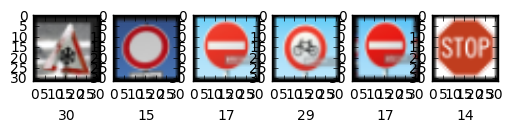

In [16]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
input_labels_file = "./test-signs.labels"
input_image_dir = "./test-signs"
with open(input_labels_file) as f:
    y_new = np.array([int(line) for line in f])
X_new = np.empty([len(y_new), 32, 32, 6], dtype=np.float32)
X_raw = np.empty([len(y_new), 32, 32, 3], dtype=np.uint8)
fig = plt.figure()
for f in os.listdir(input_image_dir):
    cv_image = cv2.imread(os.path.join(input_image_dir, f))
    cv_image = cv2.resize(cv_image, (32, 32), interpolation=cv2.INTER_AREA)
    cv_image = rotateImage(cv_image, 90, 90, 90, 0, 0, 200, 180)
    # The color channels were swapped in the input image
    cv_image_copy = np.copy(cv_image)
    cv_image[:, :, 0] = cv_image_copy[:, :, 2]
    cv_image[:, :, 2] = cv_image_copy[:, :, 0]
    index = int(f.replace(".png", ""))-1
    fig.add_subplot(1, 6, index + 1)

    X_new[index] = pre_process(cv_image)
    X_raw[index] = cv_image
    plt.imshow(cv_image)
    plt.xlabel(str(y_new[index]))
    
print("loaded new images")

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

Model restored.


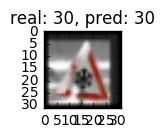

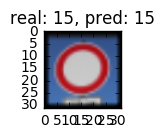

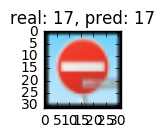

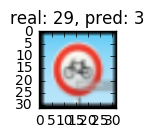

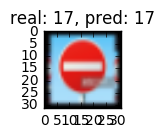

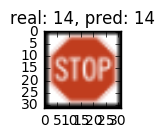

In [17]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
# NOTE: uses the flow graph from the above cells.
###
# 1. Images without subtle features like the snowflake sign/bicycle sign show a lower accuracy 
#    than ones with more pronounced features
# 2. The network is still sensitive to scale and has to be scaled correctly with the right padding
#    for good predictions. This can be fixed by better augmentation during the training process.
###
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "/tmp/model.ckpt")
    print("Model restored.")
    # Do some work with the model
    logits_results = sess.run(logits, feed_dict={x: X_new, keep_prob: 1.0})
    index = 0
    for logits_result in logits_results:
        fig = plt.figure(index+1, figsize=(1, 1), dpi=32)
        plt.imshow(X_raw[index])
        plt.title("real: %d, pred: %d" % (y_new[index], np.argmax(logits_result)))
        
        index = index + 1

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [18]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
# NOTE: uses the flow graph from the above cells.

saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "/tmp/model.ckpt")
    print("Model restored.")
    # Do some work with the model
    acc = sess.run(accuracy, feed_dict={x: X_new, y: encoder.transform(y_new).astype(np.float32), keep_prob: 1.0})
    print("accuracy on new data: %f, num test cases: %d" % (acc, len(y_new)))

Model restored.
accuracy on new data: 0.833333, num test cases: 6


In [19]:
#Analysis:
# The prediction accuracy on a sample of 6 images was 85% as opposed to
# the testing accuracy of 97%.
# The reasons for low performance on real world examples could be:
# - Overfitting, the model might not generalize well to new data, the fix 
#   would be to train with a wider range of distortions and increasing
#   dropouts and potentially adding regularization, since the last submission
#   I bumped up the dropout to 0.5 from 0.2, I didn't think it necessary
#   to add additional regularization, it would be an artifact of how the
#   model performs in the wild.
# - Learning the right features - It could be the case that the neural network
#   learns incorrect associations like focus on color more than focussing on
#   the outline of the sign or what's in the sign, a potential fix here is
#   using richer features, or an RNN by sliding a receptor on the input image,
#   or semi-supervised GANs.
# - Poor image resize algo - The specific images with the error look really
#   poor, these images could very well be beyond recognition as they're really
#   noisy. In the earlier submission, the resize algo used a linear interpolation
#   technique, I changed it to be INTER_AREA. Post fixing this issue, I got the
#   snowflake sign right too.
# - Not too scale/rotation/tranlation invariant.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

Model restored.
true label: 30, top_k predictions: [30 11 28  6 40]


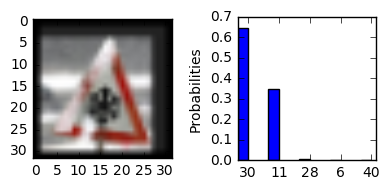

true label: 15, top_k predictions: [15 13  4  8  2]


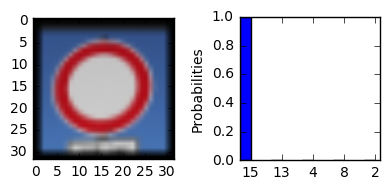

true label: 17, top_k predictions: [17 14 10  9 16]


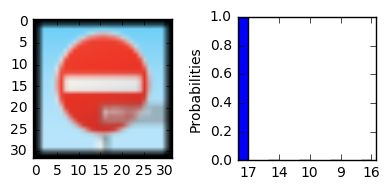

true label: 29, top_k predictions: [ 3 16  2  5  9]


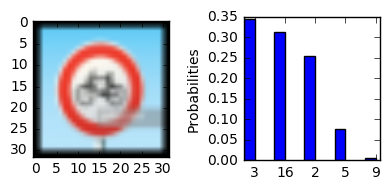

true label: 17, top_k predictions: [17 14 10  9 16]


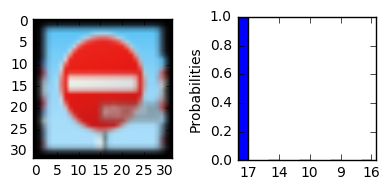

true label: 14, top_k predictions: [14 18  1 24 17]


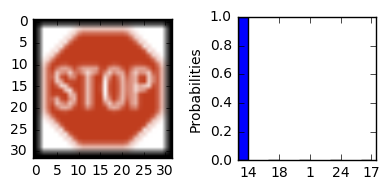

In [20]:
# NOTE: uses the flow graph from the above cells.
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "/tmp/model.ckpt")
    print("Model restored.")
    # Do some work with the model
    top_ks = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), feed_dict={x: X_new, keep_prob: 1.0})
    index = 0
    for vals, inds in zip(top_ks.values, top_ks.indices):
        print("true label: %d, top_k predictions: %s" % (y_new[index], str(inds)))
        x_pos = np.arange(len(vals))
        width = 0.35
        fig, (im_ax, ax) = plt.subplots(1, 2, figsize=(4, 2))
        rects1 = ax.bar(x_pos, vals, width, color='b')
        ax.set_ylabel('Probabilities')
        ax.set_xticks(x_pos + width)
        ax.set_xticklabels(tuple([str(ind) for ind in inds]))
        im_ax.imshow(X_raw[index])
        plt.tight_layout()
        plt.show()
        index += 1
        
# Interestingly signs like the snowflake or bicycle lose a lot of clarity while resizing to 32x32 causing
# a lot of its features to be less useful for making predictions.
# For the other samples it looks like the softmax probabilities are nearly 1.0